In [ ]:
import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from torchsummary import summary


Used in mac: mps

In [ ]:
device = torch.device('mps')
print(device)

mps


In [ ]:
image_normalize = lambda x: x / 255.

train_mnist_dataset = datasets.MNIST('/Users/noam/PycharmProjects/PyTorchAfeka/files',
                                     train=True,
                                     download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Lambda(image_normalize)
                                     ]))

test_mnist_dataset = datasets.MNIST('/Users/noam/PycharmProjects/PyTorchAfeka/files',
                                    train=False,
                                    download=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                  transforms.Lambda(image_normalize)]))
batch_size_50 = 50
batch_size_100 = 100

train_size = int(0.9 * len(train_mnist_dataset))
val_size = len(train_mnist_dataset) - train_size

train_loader_50_batch, val_loader_50_batch = random_split(
    train_mnist_dataset, [train_size, val_size])

train_loader_50_batch = DataLoader(train_loader_50_batch, batch_size=batch_size_50, shuffle=True)
val_loader_50_batch = DataLoader(val_loader_50_batch, batch_size=batch_size_50, shuffle=True)

train_loader_100_batch, val_loader_100_batch = random_split(
    train_mnist_dataset, [train_size, val_size])

train_loader_100_batch = DataLoader(train_loader_100_batch, batch_size=batch_size_50, shuffle=True)
val_loader_100_batch = DataLoader(val_loader_100_batch, batch_size=batch_size_50, shuffle=True)

test_loader_50_batch = DataLoader(test_mnist_dataset,
                                  batch_size=batch_size_50,
                                  shuffle=True)

test_loader_100_batch = DataLoader(test_mnist_dataset,
                                   batch_size=batch_size_100,
                                   shuffle=True)


In [ ]:
class PrintLayer(nn.Module):
    def __init__(self, layer_out, image=0):
        super(PrintLayer, self).__init__()
        self.image = image
        self.layer_out = layer_out

    def forward(self, x):
        imgplot = plt.imshow(x.cpu().detach().numpy()[0][0])

        self.layer_out = torch.clone(x[self.image])
        return x

In [ ]:
def init_conv2d_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        m.weight = nn.Parameter(torch.abs(m.weight))
        m.bias.data.fill_(0.01)


In [ ]:
def get_activation(name, activation):
    def hook(model, input, output):
        if name == 'conv1':
            activation["input"] = input[0]
        activation[name] = output.detach()
    return hook


In [ ]:
model_no_hidden = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),
)


In [ ]:
model_with_hidden = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)



In [ ]:
model_conv_32 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=32*14*14, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10)
  )
model_conv_32.apply(init_conv2d_weights)

model_conv_32.activation = {}

model_conv_32[0].register_forward_hook(get_activation('conv1', model_conv_32.activation))
model_conv_32[1].register_forward_hook(get_activation('conv1_Relu', model_conv_32.activation))
model_conv_32[2].register_forward_hook(get_activation('max_pool_1', model_conv_32.activation))


In [ ]:
model_conv_64 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10)
  )
model_conv_64.apply(init_conv2d_weights)


model_conv_64.activation = {}

model_conv_64[0].register_forward_hook(get_activation('conv1', model_conv_64.activation))
model_conv_64[1].register_forward_hook(get_activation('conv1_Relu', model_conv_64.activation))
model_conv_64[2].register_forward_hook(get_activation('max_pool_1', model_conv_64.activation))
model_conv_64[3].register_forward_hook(get_activation('conv2', model_conv_64.activation))
model_conv_64[4].register_forward_hook(get_activation('conv2_Relu', model_conv_64.activation))
model_conv_64[5].register_forward_hook(get_activation('max_pool_2', model_conv_64.activation))



In [ ]:
model_conv_64_with_dropout = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10)
  )
model_conv_64_with_dropout.apply(init_conv2d_weights)

model_conv_64_with_dropout.activation = {}

model_conv_64_with_dropout[0].register_forward_hook(get_activation('conv1', model_conv_64_with_dropout.activation))
model_conv_64_with_dropout[1].register_forward_hook(get_activation('conv1_Relu', model_conv_64_with_dropout.activation))
model_conv_64_with_dropout[2].register_forward_hook(get_activation('max_pool_1', model_conv_64_with_dropout.activation))
model_conv_64_with_dropout[3].register_forward_hook(get_activation('conv2', model_conv_64_with_dropout.activation))
model_conv_64_with_dropout[4].register_forward_hook(get_activation('conv2_Relu', model_conv_64_with_dropout.activation))
model_conv_64_with_dropout[5].register_forward_hook(get_activation('max_pool_2', model_conv_64_with_dropout.activation))


In [ ]:
def predict(model, data_loder):
  model.eval()
  val_predictions = []
  val_targets = []

  for (images, labels) in data_loder:
    images, labels = images.to(device), labels.to(device)

    output = model(images)

    _, predictions = torch.max(output, 1)
    val_predictions.extend(predictions.cpu().numpy())
    val_targets.extend(labels.cpu().numpy())

  return (torch.tensor(val_predictions), torch.tensor(val_targets))


In [ ]:
def score(predictions, targets, mode: str):
  accuracy = accuracy_score(targets, predictions)
  precision = precision_score(targets, predictions, average='weighted', zero_division=1)
  recall = recall_score(targets, predictions, average='weighted')
  f1 = f1_score(targets, predictions, average='weighted')
  balanced_accuracy = balanced_accuracy_score(targets, predictions)

  print(f"{mode} Results:\n")
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
  print("---------------------------------------------\n")


In [ ]:
def train_model(model, training):
  lr=1e-3
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss = torch.nn.CrossEntropyLoss()
  counter = 0
  mini_batch = 13000
  start = time.time()

  while counter < mini_batch:
    for (images, labels) in training:
      images, labels = images.to(device), labels.to(device)

      cross_entropy = loss(model(images), labels)
      # if not (counter % 30):
      #   print(cross_entropy.cpu().detach().numpy())

      optimizer.zero_grad()

      cross_entropy.backward()

      optimizer.step()

      counter += training.batch_size
      if counter < mini_batch:
        break

  end = time.time()

  print(f"Training time: {end - start:.2f} seconds")
  cal_weights(model)


In [ ]:
def train_model2(model, training, validation_loader):
  lr=1e-4
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss = torch.nn.CrossEntropyLoss()
  counter = 0
  start = time.time()

  while True:
    for (images, labels) in training:
      cross_entropy = loss(model(images.to(device)), labels.to(device))

      optimizer.zero_grad()

      cross_entropy.backward()

      optimizer.step()

      counter += 1

    predictions, targets = predict(model=model, data_loder=validation_loader)

    accuracy = accuracy_score(targets, predictions)
    if accuracy >= 0.99:
      break

  end = time.time()

  print(f"Training time: {end - start:.2f} seconds")
  print(f"Num of batch iterations: {counter}")

  cal_weights(model)


In [ ]:
def cal_weights(model):
  total_weights = 0

  # Iterate through each layer in the sequential model
  for layer in model:
      if hasattr(layer, 'weight') and layer.weight is not None:
          layer_weights = layer.weight.numel()
          total_weights += layer_weights

      if hasattr(layer, 'bias') and layer.bias is not None:
          layer_biases = layer.bias.numel()
          total_weights += layer_biases

  print(f'Total number of weights : {total_weights}\n')

In [ ]:
print("Model without hidden layers")
train_model(model_no_hidden, train_loader_50_batch)

predictions, targets = predict(model=model_no_hidden, data_loder=train_loader_50_batch)
score(predictions, targets, mode="Train")

predictions, targets = predict(model=model_no_hidden, data_loder=val_loader_50_batch)
score(predictions, targets, mode="Validation")

predictions, targets = predict(model=model_no_hidden, data_loder=test_loader_50_batch)
score(predictions, targets, mode="Test")


Model without hidden layers
Training time: 6.85 seconds
Total number of weights : 7850
Train Results:

Accuracy: 0.6821
Precision: 0.7664
Recall: 0.6821
F1 Score: 0.6537
Balanced Accuracy: 0.6701
---------------------------------------------
Validation Results:

Accuracy: 0.6787
Precision: 0.7628
Recall: 0.6787
F1 Score: 0.6470
Balanced Accuracy: 0.6698
---------------------------------------------
Test Results:

Accuracy: 0.7001
Precision: 0.7773
Recall: 0.7001
F1 Score: 0.6697
Balanced Accuracy: 0.6885
---------------------------------------------


In [ ]:
print("Model with 2 hidden layers")
train_model(model_with_hidden, train_loader_50_batch)

predictions, targets = predict(model=model_with_hidden, data_loder=train_loader_50_batch)
score(predictions, targets, mode="Train")

predictions, targets = predict(model=model_with_hidden, data_loder=val_loader_50_batch)
score(predictions, targets, mode="Validation")

predictions, targets = predict(model=model_with_hidden, data_loder=test_loader_50_batch)
score(predictions, targets, mode="Test")

Model with 2 hidden layers
Training time: 9.75 seconds
Total number of weights : 199210
Train Results:

Accuracy: 0.8315
Precision: 0.8338
Recall: 0.8315
F1 Score: 0.8317
Balanced Accuracy: 0.8290
---------------------------------------------
Validation Results:

Accuracy: 0.8340
Precision: 0.8362
Recall: 0.8340
F1 Score: 0.8342
Balanced Accuracy: 0.8317
---------------------------------------------
Test Results:

Accuracy: 0.8333
Precision: 0.8350
Recall: 0.8333
F1 Score: 0.8334
Balanced Accuracy: 0.8309
---------------------------------------------


In [ ]:
print("Model with conv 32 filters")
train_model(model_conv_32, train_loader_50_batch)

predictions, targets = predict(model=model_conv_32, data_loder=train_loader_50_batch)
score(predictions, targets, mode="Train")

predictions, targets = predict(model=model_conv_32, data_loder=val_loader_50_batch)
score(predictions, targets, mode="Validation")

predictions, targets = predict(model=model_conv_32, data_loder=test_loader_50_batch)
score(predictions, targets, mode="Test")



Model with conv 32 filters
Training time: 11.32 seconds
Total number of weights : 6434634
Train Results:

Accuracy: 0.9255
Precision: 0.9258
Recall: 0.9255
F1 Score: 0.9252
Balanced Accuracy: 0.9249
---------------------------------------------
Validation Results:

Accuracy: 0.9292
Precision: 0.9293
Recall: 0.9292
F1 Score: 0.9289
Balanced Accuracy: 0.9291
---------------------------------------------
Test Results:

Accuracy: 0.9291
Precision: 0.9295
Recall: 0.9291
F1 Score: 0.9289
Balanced Accuracy: 0.9285
---------------------------------------------


In [ ]:
train_model(model_conv_64, train_loader_50_batch)

predictions, targets = predict(model=model_conv_64, data_loder=train_loader_50_batch)
score(predictions, targets, mode="Train")

predictions, targets = predict(model=model_conv_64, data_loder=val_loader_50_batch)
score(predictions, targets, mode="Validation")

predictions, targets = predict(model=model_conv_64, data_loder=test_loader_50_batch)
score(predictions, targets, mode="Test")


Training time: 12.79 seconds
Total number of weights : 3274634
Train Results:

Accuracy: 0.9262
Precision: 0.9278
Recall: 0.9262
F1 Score: 0.9257
Balanced Accuracy: 0.9248
---------------------------------------------
Validation Results:

Accuracy: 0.9247
Precision: 0.9266
Recall: 0.9247
F1 Score: 0.9242
Balanced Accuracy: 0.9236
---------------------------------------------
Test Results:

Accuracy: 0.9298
Precision: 0.9311
Recall: 0.9298
F1 Score: 0.9293
Balanced Accuracy: 0.9284
---------------------------------------------


In [ ]:
def conv_image(model, batch:int, layer_name:str, channel:int):
    plt.figure()
    plt.title(f'{layer_name} image')
    plt.imshow(model.activation[layer_name][batch][channel].cpu())



Model with conv 64 filters


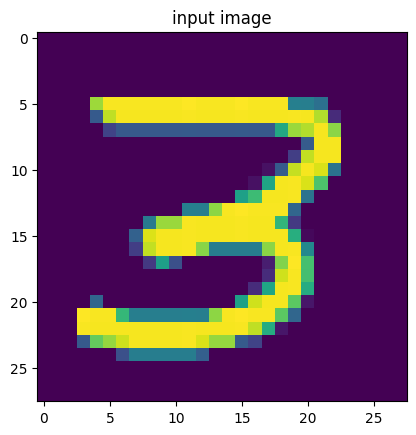

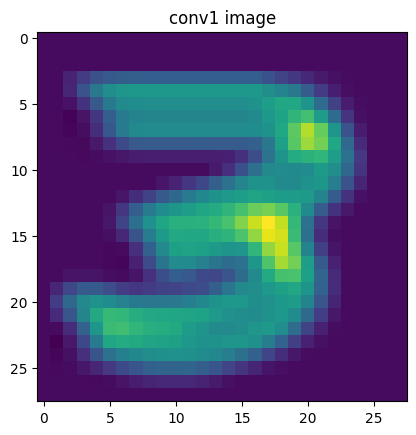

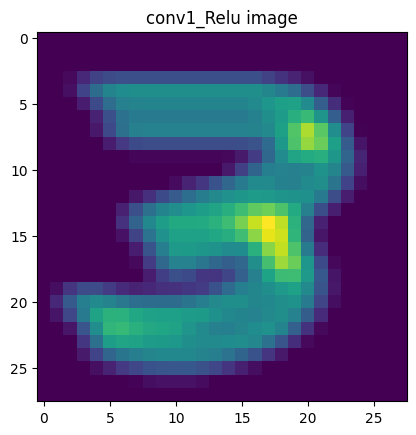

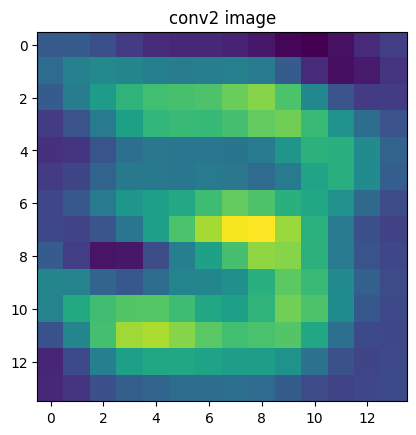

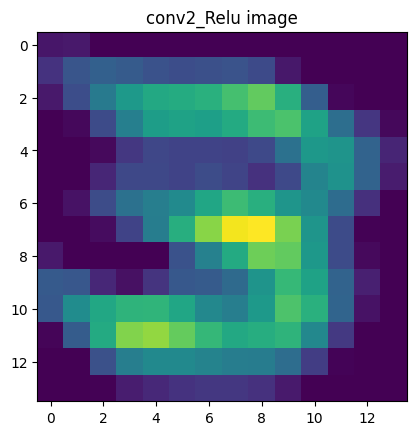

In [ ]:
print("Model with conv 64 filters")

conv_image(model_conv_64, 2, "input", 0)
conv_image(model_conv_64, 2, "conv1", 4)
conv_image(model_conv_64, 2, "conv1_Relu", 4)
conv_image(model_conv_64, 2, "conv2", 4)
conv_image(model_conv_64, 2, "conv2_Relu", 4)


In [ ]:
summary(model_conv_64.cpu(), (1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                 [-1, 1024]       3,212,288
              ReLU-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 12.49
Estima

At this point of the project, we are comparing the 2 models with the dropout, with 50 and 100 minibatches. validation accuracy of 0.99 will take a significant time for running.  

In [ ]:
print("Model with conv 64 filters with dropout - 50 minibatch")
train_model2(model_conv_64_with_dropout, train_loader_50_batch, val_loader_50_batch)

predictions, targets = predict(model=model_conv_64_with_dropout, data_loder=train_loader_50_batch)
score(predictions, targets, mode="Train")

predictions, targets = predict(model=model_conv_64_with_dropout, data_loder=val_loader_50_batch)
score(predictions, targets, mode="Validation")

predictions, targets = predict(model=model_conv_64_with_dropout, data_loder=test_loader_50_batch)
score(predictions, targets, mode="Test")

Model with conv 64 filters with dropout - 50 minibatch
0.823
0.8916666666666667
0.9101666666666667
0.9243333333333333
0.9356666666666666
0.9355
0.947
0.9468333333333333
0.9528333333333333
0.9566666666666667
0.955
0.9571666666666667
0.9625
0.9576666666666667
0.9675
0.9678333333333333
0.9665
0.9655
0.9713333333333334
0.9726666666666667
0.9735
0.9713333333333334
0.9686666666666667
0.9716666666666667
0.9743333333333334
0.9743333333333334
0.9751666666666666
0.9755
0.9773333333333334
0.9781666666666666
0.9755
0.9783333333333334
0.9783333333333334
0.9771666666666666
0.9825
0.9796666666666667
0.9785
0.9796666666666667
0.9818333333333333
0.9803333333333333
0.9805
0.9823333333333333
0.9801666666666666
0.9811666666666666
0.9813333333333333
0.982
0.9816666666666667
0.9838333333333333
0.982
0.9816666666666667


In [ ]:
print("Model with conv 64 filters with dropout - 100 minibatch")
train_model2(model_conv_64_with_dropout, train_loader_100_batch, val_loader_100_batch)

predictions, targets = predict(model=model_conv_64_with_dropout, data_loder=train_loader_100_batch)
score(predictions, targets, mode="Train")

predictions, targets = predict(model=model_conv_64_with_dropout, data_loder=val_loader_100_batch)
score(predictions, targets, mode="Validation")

predictions, targets = predict(model=model_conv_64_with_dropout, data_loder=test_loader_100_batch)
score(predictions, targets, mode="Test")